<h1> 0/ Introduction </h1>

Bonjour,

Bienvenue dans le tutoriel pour s'initier aux réseaux de neurones.
Les fonctions proposées ici servent à simplifier l'initiation et aider les radiologues motivés à mettre le pied à l'étrier

Quelques bases en python sont conseillées mais vous n'en aurez pas besoin si vous vous contentez de suivre ce tutoriel.

Pour lancer un bout de code, cliquez dessus et tappez sur ctrl + Entrée sur votre clavier


In [1]:
"""
Ceci permet d'importer les fonctions nécessaires pour la suite, celles des APIs que nous avons installées
et celle que nous proposons pour ce tutoriel.
"""
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import pandas
from PIL import Image
import random
import datetime
import scipy
import openpyxl
import time
import glob
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

import FunctionsMaster  as Tutoriel

<h1> 1/ Obtention d'un Dataset </h1>

<h2> 1A/ Création d'un dataset personnel </h2>

Pour entrainer votre réseau de neurones vous devez obtenir un dataset.
Nous vous conseillons à terme de créer vos propres données, nous fournissons plusieurs fonctions pour cette tache, 
dont la principale :
    # Dossier_DICOM_vers_ImagesPNG ( DossierDICOM , Dossier_de_sauvegarde )
    
Pour l'utiliser vous devez rentrer le dossier où se situent les fichiers DICOM à la place de "DossierDICOM" et le dossier où sauvegarder les images à la place de "Dossier_de_sauvegarde".


In [3]:
"""
Si tous les fichiers sont à la racine du dossier que vous indiquez, il suffit d'utiliser la fonction telle quelle, 
en changeant le chemin vers les dosiers pour adapter à vos conditions
"""

Tutoriel.Dossier_DICOM_vers_ImagesPNG ( r"C:\Users\alexandre\IA\DossierDICOMs" , r"C:\Users\alexandre\IA\DossierIMAGESpng" )

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\alexandre\\IA\\DossierDICOMs'

In [ ]:
"""
Si les fichiers sont dans des sous dossiers au sein du dossier que vous indiquez, il suffit d'utiliser la fonction telle quelle, 
en changeant le chemin vers les dosiers pour adapter à vos conditions
"""

Liste_des_sous_dossiers = Tutoriel.fast_scandir(r"C:\Users\alexandre\IA\DossierDICOMs")

for sousDossier in Liste_des_sous_dossiers :
    Tutoriel.Dossier_DICOM_vers_ImagesPNG (sousDossier, r"C:\Users\alexandre\IA\DossierIMAGESpng" )

<h2> 1B/ Téléchargement d'un dataset public </h2>

Pour notre exemple nous utiliserons un dataset de radiographies thoraciques, permettant de reconnaitre :
    les radiographies normales 
    vs Pneumonie 
    vs Pneumonie Covid.
    
Le dataset est téléchargeable via ce lien : https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/download
sur la page Kaggle du dataset : https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

Trions à la main le dataset en deux dossiers :
- un d'entrainement et de validation
- un de test

Dans chaque dossier nous créeons 3 sous dossiers, un pour chaque catégorie. Attention à ce que le nom des sous-dossiers corresponde.
Il est conseillé de garder une proportion globalement identique.

Nous choisissons (arbitrairement) de diviser le dataset en 80/20 : 
- 80% pour l'entrainement
- 20% le test

Voici donc la structure des dossiers à suivre :
- ...\Train_Val\Covid\ : 175 images
- ...\Train_Val\Normal\ : 1073 images
- ...\Train_Val\ViralPneumonia\ : 1076 images
- ...\Test\Covid\ : 44 images
- ...\Test\Normal\ : 268 images
- ...\Test\ViralPneumonia\ : 269 images

<h1> 2/ Lecture du Dataset </h1>

In [2]:
"""
Nous allons commencer par indiquer le chemin vers les différents dossiers de notre dataset
Pensez à changer le nom des dossiers par les votres
"""
Dossier_Train_et_validation = r"D:\IA\chest_xray\train_val"
Dossier_test                = r"D:\IA\chest_xray\test"

DS_Train_Val = pathlib.Path(Dossier_Train_et_validation)
DS_Test      = pathlib.Path(Dossier_test)


In [3]:
"""
vérifions que les catégories ont bien été interprétées
"""
CLASS_NAMES = np.array([item.name for item in DS_Train_Val.glob('*')])
print(CLASS_NAMES)
print("nombre de classes à distinguer : ",len(CLASS_NAMES))

['NORMAL' 'PNEUMONIA']
nombre de classes à distinguer :  2


In [4]:
"""
Indiquons les réglages suivants, ils seront utilisés tout le long de notre tutoriel
"""

#De la taille des images (le logiciel modifiera automatiquement les images à cette taille.)
#Une image plus grande a plus de détail mais est plus lourde, consommant plus de ressources informatiques
Hauteurimage = 175
LargeurImage = 250
NombreChannels = 1 #Grayscale =1, couleur =3
#Donc nos images correspondent à :
IMG_SHAPE = (Hauteurimage,LargeurImage, NombreChannels)

#Du nombre d'image que notre ordinateur travaillera en parallèle
#Cela correspond au débit du 'pipeline' de notre generator
BATCH_SIZE = 10

#Du nombre d'epochs
#c'est à dire le nombre de fois que notre dataset sera transmis au réseau de neurones pour l'entrainement
EPOCHS = 15

In [5]:
"""
Créons les pipelines pour la data-augmentation
"""

#Définissons les réglages de la data augmentation voulue
data_gen_args = dict(rotation_range=15.,
                     horizontal_flip = False,
                     vertical_flip = False,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.3,
                     fill_mode = 'nearest',
                     validation_split = 0.11, #Permet la séparation automatique entre jeux d'entrainement et de validation
                     rescale = 1/255. #les images en png ont des pixels dont la valeur varie entre 0 et 255, nous ramenons cette valeur à 0-1 pour limiter les calculs nécessaires par le réseau.
                    )

image_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(rescale = 1/255.)

seed = 42 #Ce nombre est arbitraire, vous pouvez le remplacer par ce que vous voulez, il correspond au point de départ pour les
#deux pipelines, le seul critère important est qu'ils aient le même point de départ

"""
#Nous définissons 3 generators : 
#    - un pour les images et leur label pour le jeu d’entrainement
#    - un pour les images et leur label pour le jeu de validation
#    - un pour les images et leur label pour le jeu de test
"""

training_generator   = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "grayscale",
                                                         subset = "training",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

validation_generator = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "grayscale",
                                                         subset = "validation",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

testing_generator    = test_datagen.flow_from_directory(DS_Test,
                                                        color_mode = "grayscale",
                                                        target_size=(Hauteurimage,LargeurImage),
                                                        batch_size=BATCH_SIZE,
                                                        seed=seed)


Found 4691 images belonging to 2 classes.
Found 579 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


<h1> 3/ Création du Réseau de neurones </h1>

In [7]:
model = None #Cette ligne simple s'assure d'éviter un bug dans le cas où vous utilisierez cette fonction plusieurs fois
"""
Nous proposons une fonction prête à l'emploi pour créer un réseau basique de labellisation.
Bien entendu il existe de multiples facons de créer un réseau et nous vous conseillons fortement d'aller faire vos propres
essais, en vous inspirant de notre code ou de la littérature
"""

#Nous créons notre réseau 'model' à partir de la fonction toute faite
#Elle affichera automatiquement le contenu du réseau que nous avons créé :
model = Tutoriel.build_cnn (IMG_SHAPE, #Cela correspond à la taille des fichiers que le réseau recoit en entrée, soit nos images
                                sortie =len(CLASS_NAMES) #Le nombre de catégories prévues
                                )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 173, 248, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 246, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 123, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 123, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 121, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 81, 119, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 59, 64)        0

<h1> 4/ Entrainement du Réseau de neurones </h1>

In [8]:
"""
La fonction 'fit' déclenche l'entrainement.
Il faut indiquer les datasets d'entrainement et de valdiation, dans notre cas leur generator respectif
Le nombre d'epochs
Le nombre d'étapes nécessaires pour faire passer tout le dataset en fonction de la taille du Batch.
"""

TRAIN_STEPS_SIZE_TEST = training_generator.n   // training_generator.batch_size
VAL_STEPS_SIZE_TEST   = validation_generator.n // validation_generator.batch_size


history = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator)

#history : la fonction enregistre dans cette donnée la qualités des résultats au cours du temps

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 469 steps, validate for 57 steps
Epoch 1/15
469/469 [==============================] - 55s 118ms/step - loss: 0.5131 - accuracy: 0.7430 - val_loss: 0.4536 - val_accuracy: 0.7386
Epoch 2/15
469/469 [==============================] - 54s 115ms/step - loss: 0.4228 - accuracy: 0.8043 - val_loss: 0.3969 - val_accuracy: 0.7947
Epoch 3/15
469/469 [==============================] - 54s 115ms/step - loss: 0.4117 - accuracy: 0.8169 - val_loss: 0.3757 - val_accuracy: 0.8298
Epoch 4/15
469/469 [==============================] - 54s 116ms/step - loss: 0.3844 - accuracy: 0.8304 - val_loss: 0.3760 - val_accuracy: 0.8105
Epoch 5/15
469/469 [==============================] - 54s 116ms/step - loss: 0.3500 - accuracy: 0.8515 - val_loss: 0.3884 - val_accuracy: 0.7965
Epoch 6/15
469/469 [==============================] - 54s 115ms/step - loss: 0.3399 - accuracy: 0.8686 - val_loss: 0.3169 - val_accuracy: 0.8439
Epoch 7/15
469/469 [=================

<h1> 5/ Evaluation des résultats </h1>

Évaluons la qualité de nos résultats :
- nous pouvons commencer par afficher les résultats obtenus au cours de l'entrainement sur nos jeux d'entrainement et de validation.
- Ensuite nous allons l'évaluer sur le jeu de test, c'est-à-dire des images qu'il n'a jamais vues. Ceci nous permettra de comparer les résultas prédits par le réseau de la labellisation qui leurs avaient été donnée.

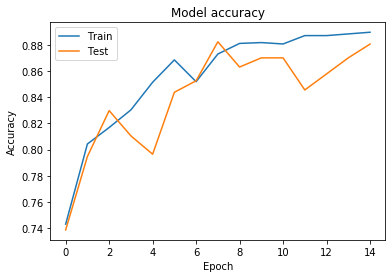

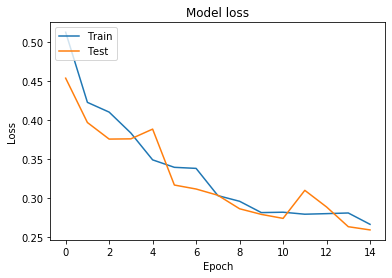

In [9]:
"""
Commencons par afficher les résultats de l'entrainement au cours du temps
"""

# Accuracy = precision = (VP + VN)/total
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Calcul de la fonction de coût (plus bas est le mieux), sa valeur dépend de son calcul et du réglage du réseau de neurones
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
"""
Le meilleur moyen pour évaluer un réseau de neurones et de le tester sur un jeu de données de test : 
des images qu'il n'a jamais vues.
Utilisons le generator que nous avons créé au départ à cet effet : 'testing_generator'
A noter que nous ne réalisons pas de modification des images dans ce generator, nous nous contentons simplement de les regarder
"""

TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

  ...
    to  
  ['...']
58/58 [==============================] - 4s 72ms/step - loss: 0.2785 - accuracy: 0.8569
loss  :  0.27848663322370626
accuracy  :  0.8568966


4/3 [=====================================] - 0s 72ms/step


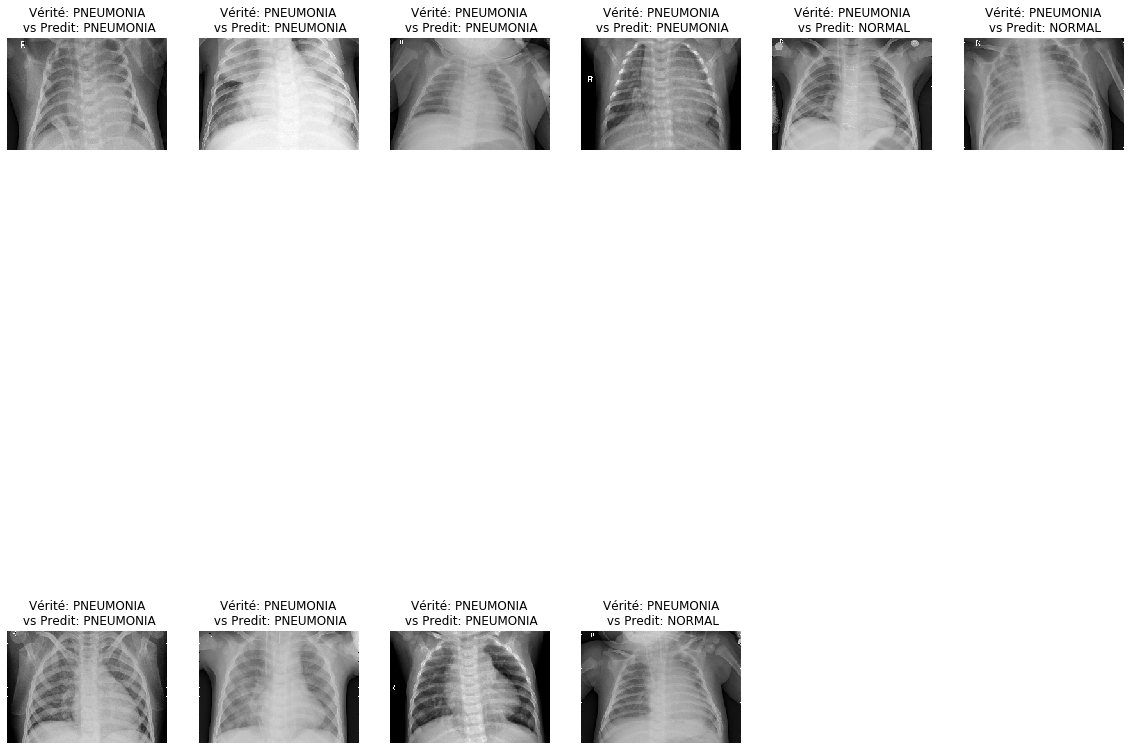

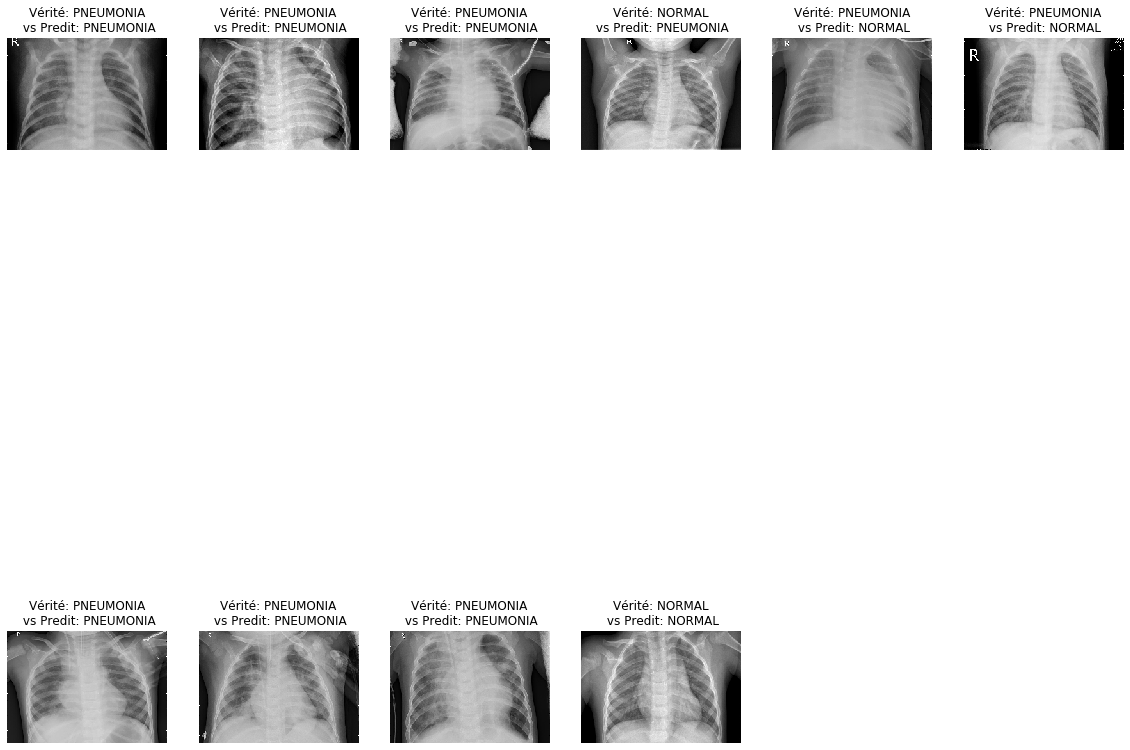

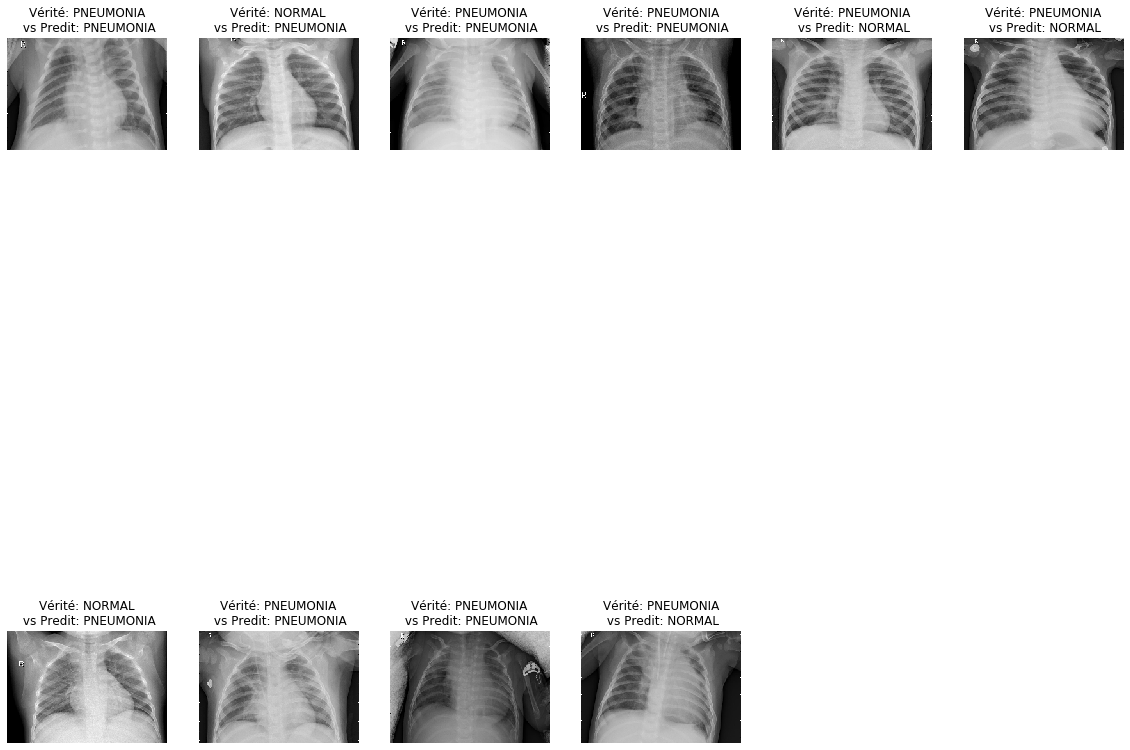

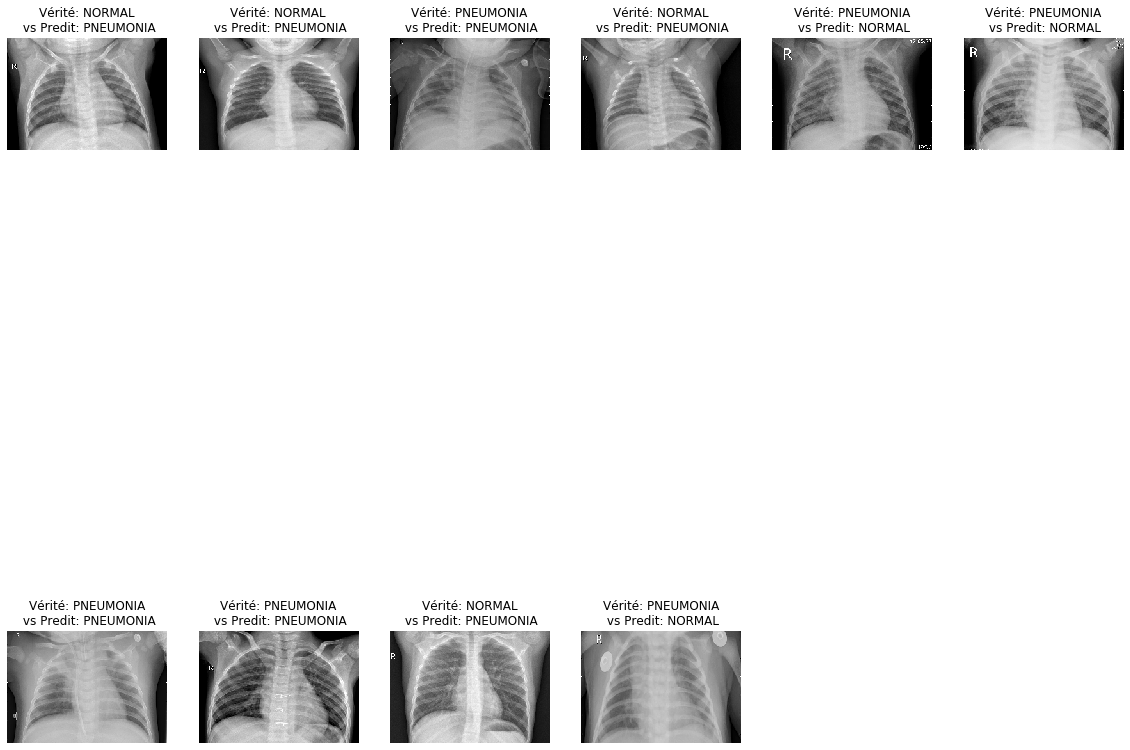

In [11]:
"""
Affichons les résultats en image avec en titre ce que le réseau a prédit et ce qu'il aurait dû prédire
Nous fournissons une fonction simple pour cet usage,
n'hésitez pas à la lancer plusieurs fois pour défiler en plusieurs fois le long du generator !
"""

Tutoriel.ComparaisonResultats(Nombre_a_afficher = 32,
                              model             = model,
                              test_gen          = testing_generator, 
                              categories        = list(CLASS_NAMES), 
                              color             = "gray", 
                              colonnes          = 6, 
                              reset             = False
                             )

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.28      0.33      0.30       159
   PNEUMONIA       0.73      0.69      0.71       427

    accuracy                           0.59       586
   macro avg       0.51      0.51      0.51       586
weighted avg       0.61      0.59      0.60       586

Confusion Matrix


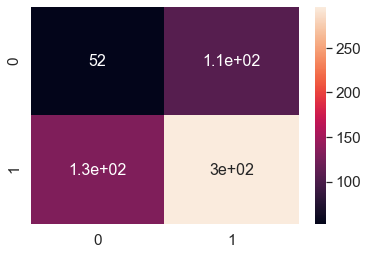

In [12]:
"""
Une autre possibilité pour afficher les résultats est de créer une MATRICE DE CONFUSION
Elle représente les vrais négatifs, faux négatifs, faux positifs et vrai spositifs dans un tableau.
"""

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sn

Y_pred = model.predict(testing_generator, steps=testing_generator.n//testing_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=list(CLASS_NAMES)))

print('Confusion Matrix')
df_cm = pandas.DataFrame(confusion_matrix(testing_generator.classes, y_pred), range(2), range(2))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

Les résultats obtenus par notre réseau dans les réglages les plus simples sont donc un peu meilleur que le hasard mais n'ont que peu d'intéret. Notre réseau était très simple et il est probablement possible de faire bien mieux !
Nous voyons les différents moyens de l'améliorer durant les étapes suivantes

<h1> 6/ Optique d'amélioration </h1>

<h2> 6a/ Correction du désiquilibre de classes </h2>

In [15]:
#Nous allons pondérer les résultats par la proportion de 3 classes, voici une méthode simple pour le faire :
total = training_generator.n
weight_for_Normal         = (1 / 1424)*(total)/2.0 
weight_for_ViralPneumonia = (1 / 3846)*(total)/2.0

Ponderation = {0: weight_for_Normal, 
               1: weight_for_ViralPneumonia}

print("Nom des classes", CLASS_NAMES)
print("Nombre total d'images :", total)
print("ponderation", Ponderation)

Nom des classes ['NORMAL' 'PNEUMONIA']
Nombre total d'images : 4691
ponderation {0: 1.6471207865168538, 1: 0.6098543941757671}


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 173, 248, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 171, 246, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 123, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 85, 123, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 83, 121, 64)       18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 81, 119, 64)       36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 59, 64)       

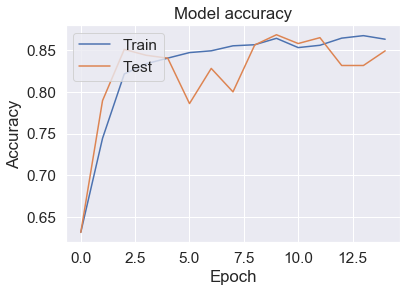

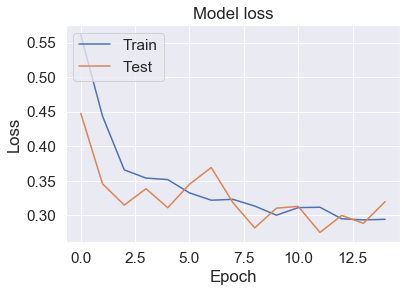

In [16]:
#Redéfinissons notre réseau de neurones puis nous l'entrainons en prenant en compte cette pondération
model = None
model = Tutoriel.build_cnn (IMG_SHAPE, #Cela correspond à la taille des fichiers que le réseau recoit en entrée, soit nos images
                                sortie =len(CLASS_NAMES) #Le nombre de catégories prévues
                               ) 
    
historyAvecPonderation = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator,
                    class_weight=Ponderation #C'est cette ligne qui nous permet d'ajouter une pondération
                                  ) 

#Puis nous affichons ces résultats :
plt.plot(historyAvecPonderation.history['accuracy'])
plt.plot(historyAvecPonderation.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(historyAvecPonderation.history['loss'])
plt.plot(historyAvecPonderation.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

  ...
    to  
  ['...']
58/58 [==============================] - 4s 71ms/step - loss: 0.3430 - accuracy: 0.8466
loss  :  0.34301472301113195
accuracy  :  0.8465517


<h2> 6b/ Utilisation d'un autre reseau </h2> 

Notre réseau jusque là était relativement simple, les réglages de base de notre fonction Tutoriel.build_cnn fournissent en effet une fonction relativement simple, correspondant au CNN le plus basique.
Notre fonction permet de créer facilement un réseau bien plus complexe, en permettant de modifier :

- l’optimizer : il s’agit de la formule qui détermine comment le réseau doit adapter ses réglages internes. Il existe plusieurs façon de déterminer comment les poids des neurones doivent être corrigés: Certains optimizers possèdent une inertie.


- le learning rate : correspond à la taille du pas de modification. C’est un paramètre majeur, il est dépendant l’optimizer choisi.


- le Nombre de blocs de convolution : dans sa version de base un réseau de type CNN correspond à une à deux couche(s) de neurones de convolution et d’une couche de maxpooling (qui peut être interprété comme un Maximal Intesity Projection (MIP) sur plusieurs pixels adjacents). Il est possible de répéter les blocs de convolution et ce que permet ce réglage.


- Nombre de feature maps : Il s’agit du nombre de filtres d’image utilisés pour interpréter l’image. Ce nombre est multiplié automatiquement par deux à chaque bloc de convolution.


- Kernel size : correspond à la largeur des filtres utilisés. Un filtre trop large peut perdre le détail de l’image alors qu’un filtre trop petit peut se perdre dans des détails en perdant l’information globale. En général ces filtres font entre 3 et 7 pixels de côté.


- Fonction d’activation : cette fonction indique comment est interprétée l’activation des différents neurones d’une couche avant le passage à la couche suivante. Il existe de multiples fonctions d’activation décrites dans la littérature [68] parmi lesquelles nous conseillons “selu” [69] et "leaky-relu" [70]. La fonction “relu” étant souvent utilisée dans la littérature, nous avons choisi celle-ci comme réglage par défaut.


- Dropout : Le dropout est une méthode de régularisation. Pendant l’entraînement, un certain nombre de résultats sont ignorés de manière aléatoire selon une certaine probabilité. Cela a pour effet de limiter l’overfitting. A chaque époque les neurones ignorés sont de nouveau tirés au hasard. Nous conseillons un dropout maximal de 0,5 en fin de réseau [71] et 0.2 en début de réseau. En effet au delà de 0,5 de probabilité le dropout diminue les capacités d’apprentissage du réseau sans augmenter son effet sur l’overfitting [72].


- Normalisation par batch : la normalisation par batch permet d'accélérer l'entraînement du réseau. Son mécanisme est en revanche débattu [73]. Son effet peut cependant s’avérer péjoratif sur les batch de petite taille [74], son usage est également à éviter avec l’usage du dropout.


- Couche entièrement connectée : elle correspond à la taille de l’avant dernière couche de neurones, s’occupant d’agréger les résultats des couches précédentes.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 173, 248, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 171, 246, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 123, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 85, 123, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 83, 121, 64)       18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 81, 119, 64)       36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 40, 59, 64)       

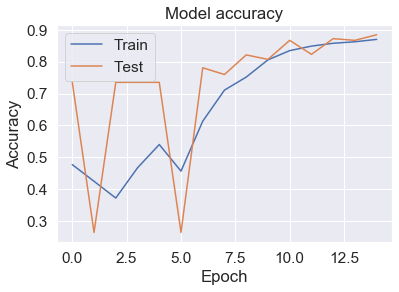

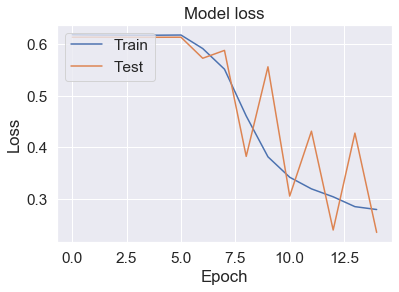

  ...
    to  
  ['...']
58/58 [==============================] - 4s 73ms/step - loss: 0.2926 - accuracy: 0.8793
loss  :  0.29263924550393533
accuracy  :  0.87931037


In [18]:
model = None
model = Tutoriel.build_cnn (IMG_SHAPE, #Cela correspond à la taille des fichiers que le réseau recoit en entrée, soit nos images
                                sortie =len(CLASS_NAMES), #Le nombre de catégories prévues
                                #tous les réglages suivants sont optionnels, la fonction peut fonctionner avec uniquement les 
                                #réglages d'entrée et de sortie !!
                                optimizer            = "Adam",   #parmi 'Adam','Adamax','Nadam','RMSprop','SGD'
                                Learning_rate_custom = 0.0001, #nombre entre 0 et 1, ou None pour utiliser les réglages par défaut
                                nombre_de_blocs      = 5, #nous conseillons entre 1 et 4
                                feature_maps         = 32, #nous conseillons 16, 32 ou 64
                                Kernel_size          = 3, #nous conseillons 3, 5 ou 7
                                activation           = "relu", #parmi ['sigmoid', 'relu', 'elu', 'leaky-relu', 'selu', 'gelu']
                                dropout_rate         = 0.5, #entre 0 et 0.5
                                batch_Norm           = False, #True ou False
                                couche_entierement_connectee = 256 #entre 64 et 512
                               )
    
nouvelEssai = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator,
                    class_weight=Ponderation)

#Puis nous affichons ces résultats :
plt.plot(nouvelEssai.history['accuracy'])
plt.plot(nouvelEssai.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(nouvelEssai.history['loss'])
plt.plot(nouvelEssai.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

4/3 [=====================================] - 0s 87ms/step


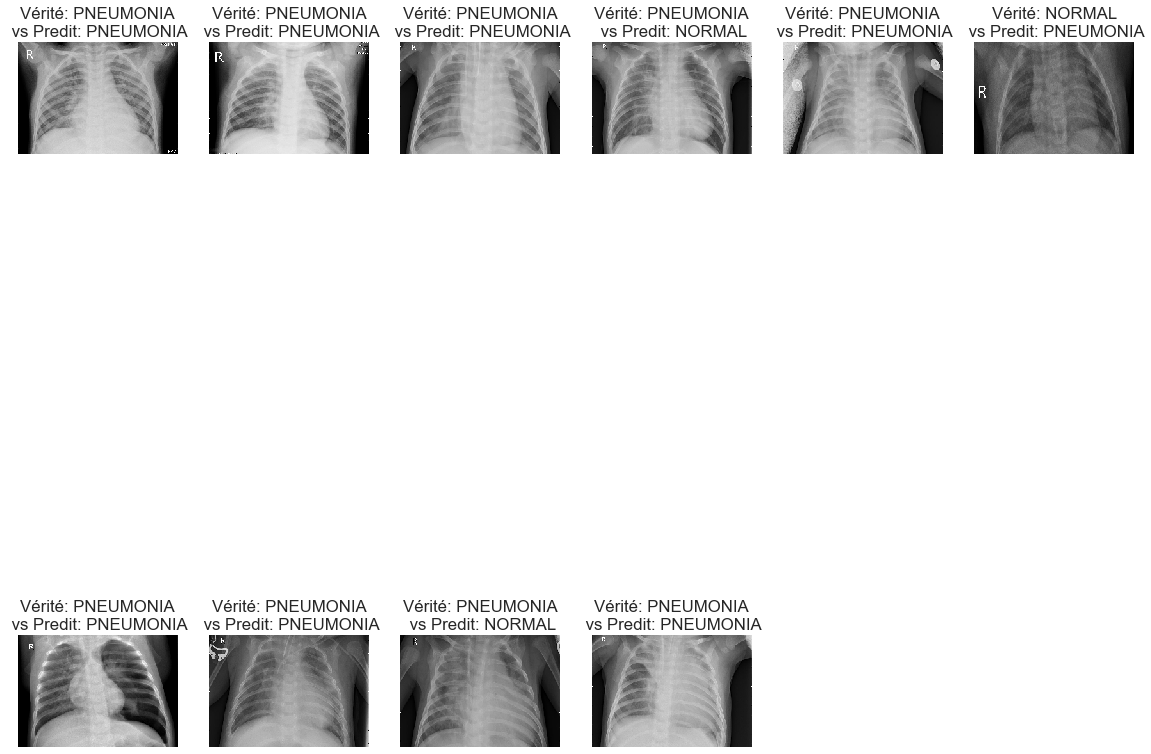

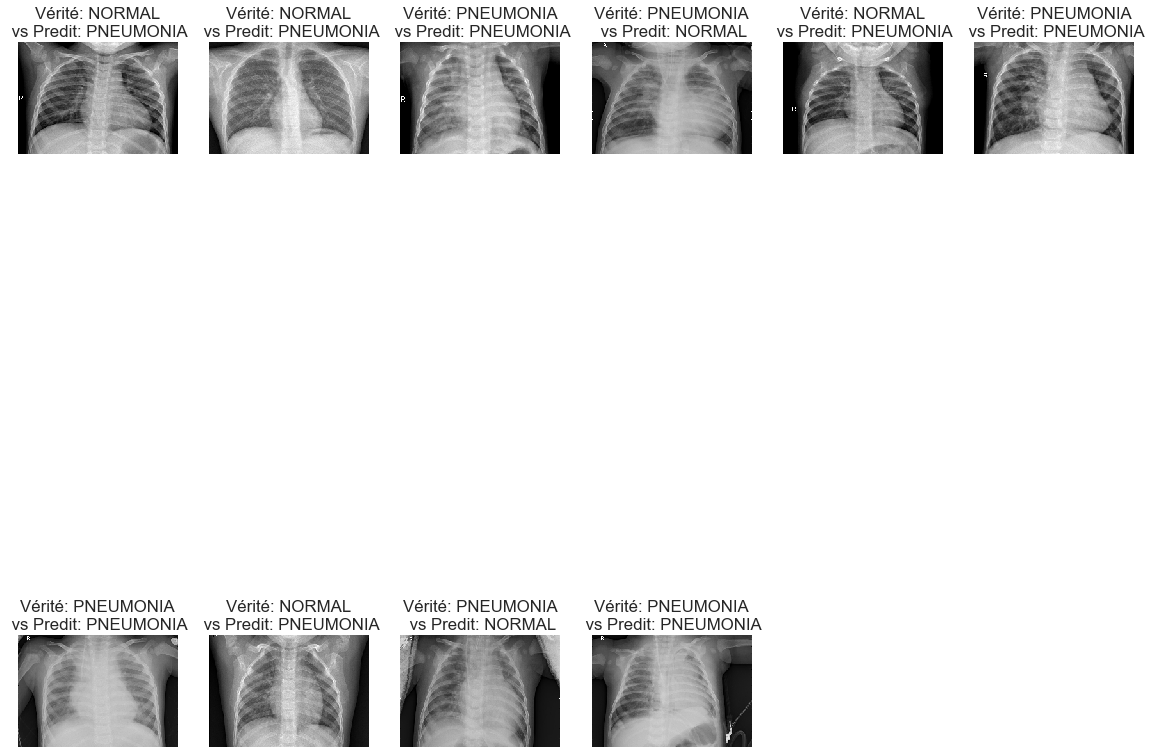

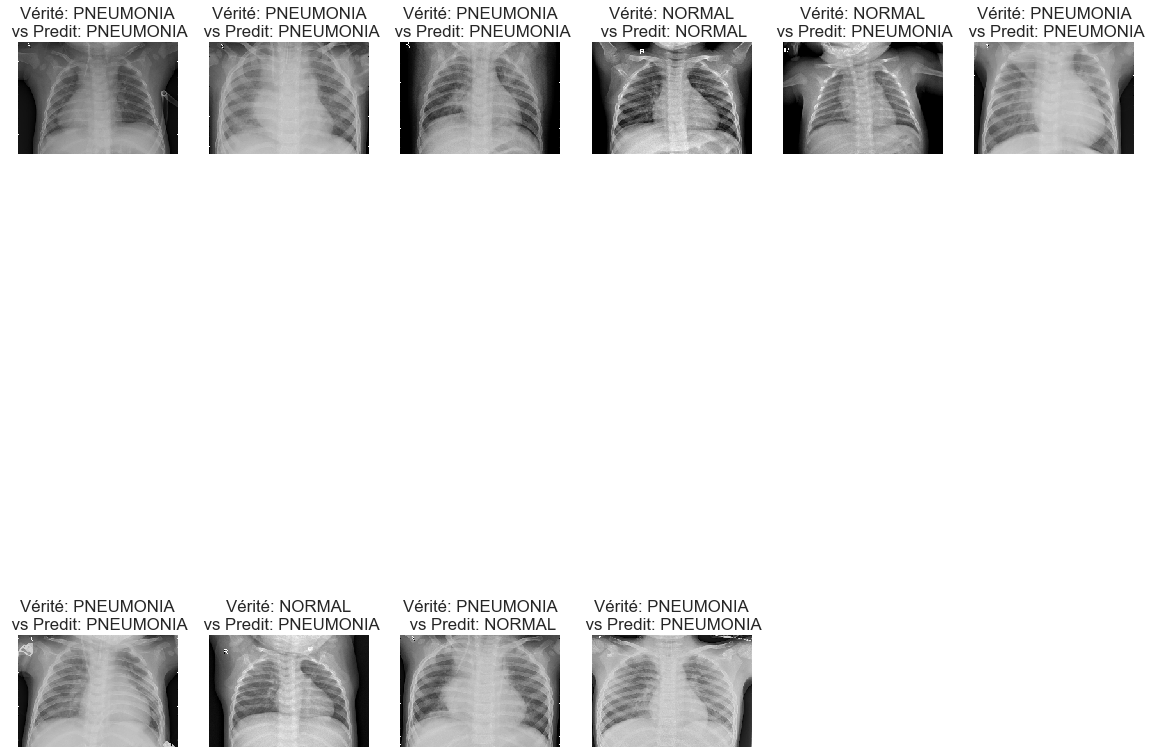

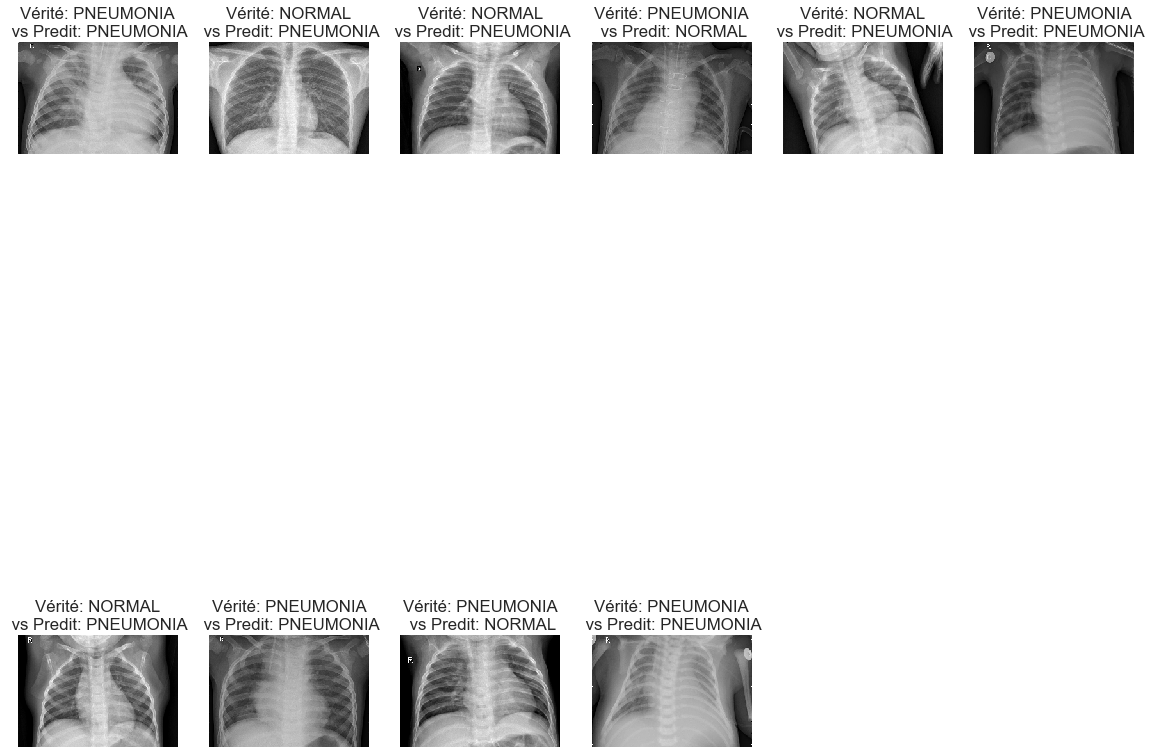

In [19]:
Tutoriel.ComparaisonResultats(Nombre_a_afficher = 32,
                              model             = model,
                              test_gen          = testing_generator, 
                              categories        = list(CLASS_NAMES), 
                              color             = "gray", 
                              colonnes          = 6, 
                              reset             = False
                             )

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.26      0.36      0.30       159
   PNEUMONIA       0.72      0.61      0.66       427

    accuracy                           0.55       586
   macro avg       0.49      0.49      0.48       586
weighted avg       0.60      0.55      0.57       586

Confusion Matrix


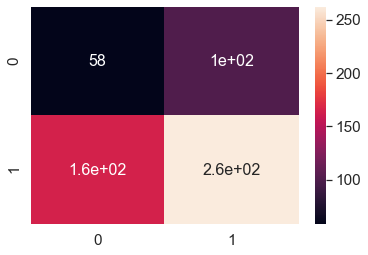

In [20]:
"""
MATRICE DE CONFUSION
"""

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sn

Y_pred = model.predict(testing_generator, steps=testing_generator.n//testing_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=list(CLASS_NAMES)))

print('Confusion Matrix')
df_cm = pandas.DataFrame(confusion_matrix(testing_generator.classes, y_pred), range(2), range(2))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

<h2> 6c/ Transfer Learning </h2> 

Le transfer Learning consiste à utiliser un réseau déjà existant,avec une architecture et surtout des réglages internes (weights) déjà optimisés pour une tache et de l'adapter puis ré-entrainer sur nos propres images (nous parlons de fine-tuning).


Il existe dans la littérature de multiples réseaux disponibles à l'emploi.
Ce sont des réseaux potentiellement complexes, avec énormément de réglages internes, ayant nécessité des puissances de calcul que nous n'avons pas à notre niveau.
Keras propose un accès faciles à plusieurs réseaux de ce type :

- Xception :

- InceptionV3

- ResNet50

- VGG16

- VGG19

- MobileNetV2

Ces réseaux ont été entrainés à distinguer 1000 classes différentes, nous retirons cette dernière couche et la remplacons par quelques couches adaptées aux classes que nous voulons distinguer.
Il y a deux entrainements à réaliser :
- avant fine-tuning, nous n'entrainons que ces dernières couches que nous avons ajoutées, le réseau que nous avons importé est gelé. Cet entrainement est rapique car il n'y a que peu de couches à entrainer
- après fine-tuning nous libérons les couches du réseau que nous avons importé et nous réalisons l'entrainement de l'ensemble en modifiant les "weights" du réseau que nous avons téléchargé.

Si Keras permet de télécharger facilement ces réseaux, il faut tout de même quelques lignes de code pour les adapter, nous avons regroué tout ceci pour le tutoriel dans une fonction.

        Tutoriel.TransferLearning()
                        
Voici les paramètres à rentrer :
- entree : tuple, la taille des images à utiliser et le nombre de channels couleur (3 obligatoires !)
a noter que si la taille est laissée libre, ces réseaux ont été entrainés sur des images d'une définition prédéfinie et 
fonctionneront mieux sur des images de taille proche :    VGG16 et VGG19 : 224x224   ;    Xception : 299x299
- sortie : int, le nombre de classes voulues en sortie, correspond au nombre de sous dossiers si vous utilisez keras.
- training_generator : generator keras, correspondant au training
- validation_generator : generator keras, correspondant à la validation
- nombre_epochs_avant_finetuning : int, 2 à 8 epochs suffiront probablement
- nombre_epochs_apres_finetuning : int, nombre après finetuning
- Model_dOrigine : parmi : "Xception", "InceptionV3", "ResNet50", "VGG16", "VGG19", "MobileNetV2"
- optimizer : liste de 2x string, nom de l'optimizer pour avant et après fine-tuning. Selon Tensorflow, exemples : 
'Adam','Adamax','Nadam','RMSprop','SGD'
- Learning_rate_custom = liste de 2x string ou 'None', modifie le learning rate pour avant et après fine-tuning, 
disponible 
uniquement pour les  optimizer suivants : parmi ['Adam','Adamax','Nadam','RMSprop','SGD'],  'None' prend le learning 
rate par défaut défini dans le code de Tensorflow
- class_weight : dict, pondérations à appliquer sur les classes.

In [21]:
"""
Nous sommes obligés de redéfinir nos generator car les réseaux pour le transfer learning n'acceptent que des images en couleur, 
donc sur 3 channels.
"""

#Réglages sur 3 channels
#A noter que  si la taille est laissée libre, ces réseaux ont été entrainés sur des images d'une définition prédéfinie et 
#fonctionneront mieux sur des images de taille proche : VGG16 et VGG19 : 224x224 ; Xception : 299x299
Hauteurimage = 224
LargeurImage = 224
NombreChannels = 3 #Grayscale =1, couleur =3
IMG_SHAPE = (Hauteurimage,LargeurImage, NombreChannels)

#Du nombre d'image que notre ordinateur travaillera en parallèle
#Cela correspond au débit du 'pipeline' de notre generator
BATCH_SIZE = 6

#Du nombre d'epochs
#c'est à dire le nombre de fois que notre dataset sera transmis au réseau de neurones pour l'entrainement
#Nous distinguons avant et après fine-tuning
EPOCHS_BEFORE = 4
EPOCHS_AFTER = 20

training_generator   = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "rgb",
                                                         subset = "training",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

validation_generator = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "rgb",
                                                         subset = "validation",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

testing_generator    = test_datagen.flow_from_directory(DS_Test,
                                                        color_mode = "rgb",
                                                        target_size=(Hauteurimage,LargeurImage),
                                                        batch_size=BATCH_SIZE,
                                                        seed=seed)


Found 4691 images belonging to 2 classes.
Found 579 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [23]:
model = None
model, hist1, hist2 = Tutoriel.TransferLearning(entree = IMG_SHAPE,
                                                 sortie =3,
                                                 training_generator = training_generator, 
                                                 validation_generator = validation_generator,
                                                 nombre_epochs_avant_finetuning = EPOCHS_BEFORE,
                                                 nombre_epochs_apres_finetuning = EPOCHS_AFTER,
                                                 Model_dOrigine       = "VGG19", #"Xception", "InceptionV3", "ResNet50", "VGG16", "VGG19", "MobileNetV2"
                                                 optimizer            = ["Adam","RMSprop"],
                                                 Learning_rate_custom = [None,0.0001],
                                                 class_weight         = Ponderation
                                                )

58892288/58889256 [==============================] - 70s 1us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 15,895,363
Trainable params: 1,180,675
N

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  logits and labels must be broadcastable: logits_size=[6,3] labels_size=[6,2]
	 [[node loss/dense_7_loss/softmax_cross_entropy_with_logits (defined at C:\Users\alexa\IA\Master\FunctionsMaster.py:792) ]]
	 [[loss/dense_7_loss/weighted_loss/broadcast_weights/assert_broadcastable/is_valid_shape/else/_1/has_valid_nonscalar_shape/then/_53/has_invalid_dims/_28]]
  (1) Invalid argument:  logits and labels must be broadcastable: logits_size=[6,3] labels_size=[6,2]
	 [[node loss/dense_7_loss/softmax_cross_entropy_with_logits (defined at C:\Users\alexa\IA\Master\FunctionsMaster.py:792) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_80531]

Function call stack:
distributed_function -> distributed_function


In [ ]:
"""
Affichons les résultats en distinguant l'entrainement avant et après fine-tuning :
"""

plt.plot(np.concatenate((hist1.history['accuracy'], hist2.history['accuracy']), axis=0), label='Training Accuracy')
plt.plot(np.concatenate((hist1.history['val_accuracy'], hist2.history['val_accuracy']), axis=0), label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot([EPOCHS_BEFORE,EPOCHS_BEFORE],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(np.concatenate((hist1.history['loss'], hist2.history['loss']), axis=0), label='Training Loss')
plt.plot(np.concatenate((hist1.history['val_loss'], hist2.history['val_loss']), axis=0), label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.plot([EPOCHS_BEFORE,EPOCHS_BEFORE],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.show()

In [ ]:
"""
Affichons les résultats en image avec en titre ce que le réseau a prédit et ce qu'il aurait dû prédire
Nous fournissons une fonction simple pour cet usage,
n'hésitez pas à la lancer plusieurs fois pour défiler en plusieurs fois le long du generator !
"""

Tutoriel.ComparaisonResultats(Nombre_a_afficher = 32,
                              model             = model,
                              test_gen          = testing_generator, 
                              categories        = list(CLASS_NAMES), 
                              color             = "gray", 
                              colonnes          = 4, 
                              reset             = False
                             )

<h1> 7/ Sauvegarde des résultats </h1> 

Une fois notre modèle efficace, il est possible de l'enregistrer.

La fonction correspond à model.save(<dossier>)

In [ ]:
NOM_DU_DOSSIER = r"C:\Users\alexa\IA\Master"
NOM_DU_MODEL = r"MonModel"

model.save(os.path.join(NOM_DU_DOSSIER, NOM_DU_MODEL))

In [9]:
"""
Pour charger un model pré-existant il suffit de faire la fonction inverse :
"""
NOM_DU_DOSSIER = r"C:\Users\alexa\IA\Master"
NOM_DU_MODEL = r"MonModel"

model = tf.keras.models.load_model(os.path.join(NOM_DU_DOSSIER, NOM_DU_MODEL))